In [1]:
"""Inspiration : https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb"""

'Inspiration : https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb'

In [6]:
from pathlib import Path
import torch

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/drive/MyDrive/research")
    CHECKPOINT_DIR = DATA_ROOT/"vit_cifar_checkpoints"
except:
    DATA_ROOT = Path.home()/"Desktop/research"
    CHECKPOINT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints"

if not DATA_ROOT.exists():
    DATA_ROOT.mkdir()
    print("Created Data dir")
else:
    print("DATA_ROOT exists at : ", DATA_ROOT)
    
if not CHECKPOINT_DIR.exists():
    CHECKPOINT_DIR.mkdir()
    print("created CKPT dir")
else:
    print("ckpt exists at : ", CHECKPOINT_DIR)
    
NUM_EPOCHS=5
BATCH_SIZE=16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_ROOT exists at :  /home/avishkar/Desktop/research
created CKPT dir


In [7]:
"""DATASET"""
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


torch.manual_seed(42)

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)

train_dataset = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform= transform)
test_dataset = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform= transform)
# print(len(train_dataset))
# print(len(test_dataset))
classes = train_dataset.classes

trainset = torch.utils.data.Subset(train_dataset, list(range(5000)))
testset = torch.utils.data.Subset(test_dataset, list(range(1000)))

valid_size = 0.2

# get training indices that wil be used for validation
train_size = len(trainset)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

# trainset = torch.utils.data.Subset(train_dataset, list(range(5000)))
# testset = torch.utils.data.Subset(test_dataset, list(range(1000)))
# print(f"trainset : {len(trainset)}, testset : {len(testset)}")


KeyboardInterrupt: 

In [13]:
# ! du -sh /home/nixocid/desktop/research/cifar-10-batches-py

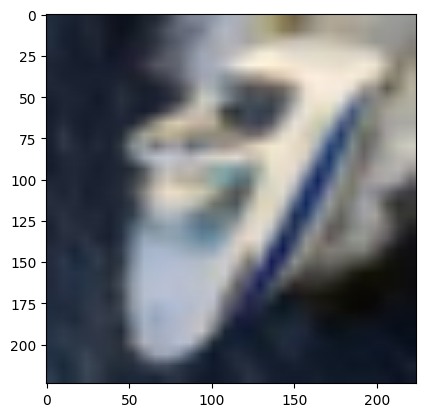

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [33]:
"""VISUALIZE DATA"""
import matplotlib.pyplot as plt

for i, (imgs, _) in enumerate(train_loader):
    img = imgs[0]
    plt.imshow(img.T.cpu().numpy())
    plt.show()
    break
    
print(train_dataset.classes)


In [14]:
"""MODEL PRE-requisited"""
import torch.nn as nn

# Patching from Images
def patch_test():
    for i, (imgs, _) in enumerate(train_loader):
        img = imgs[0]
        plt.imshow(img.T.cpu().numpy())
        plt.show()

        
        break

# Position Embeddings
try:
    E = nn.Parameter(torch.randn(1, P * P * C, D))
except:
    print("chalta hai")

chalta hai


In [41]:
"""MODEL"""
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim=768, key_dim=64):
        super().__init__()
        self.embed_dim = embed_dim # Embed dimensions for image
        self.key_dim = key_dim
        self.W = nn.Parameter(torch.randn(embed_dim, 3*key_dim))
        

    def forward(self, x):
        qkv = torch.matmul(x, self.W)
        q = qkv[:, :, :self.key_dim]
        k = qkv[:,:, self.key_dim:self.key_dim*2]
        v = qkv[:,:, self.key_dim*2:]

        # compute dot product of the all query with all keys  
        k_T = torch.transpose(k, -2, -1)   # get transpose of key
        dot_products = torch.matmul(q, k_T)

        scaled_dot_products = dot_products / np.sqrt(key_dim)
        attention_weights = F.softmax(scaled_dot_products, dim=1)
        weighted_values = torch.matmul(attention_weights, v)

        return weighted_values

"""Self Attention usage

D = 768 # Patch embeddings
D_h = 64 # q,k,v embeddings
B = 1 # batch size

# convert flattened patches to tensor
x_p = torch.Tensor(x_p)

# add batch dimension
x_p = x_p[None, ...]    

# weight matrix E
E = nn.Parameter(torch.randn(1, P * P * C, D))

patch_embeddings = torch.matmul(x_p , E)

class_token = nn.Parameter(torch.randn(1, 1, D))
patch_embeddings = torch.cat((class_token, patch_embeddings), 1)

self_attention = SelfAttention(D, D_h)
attention_scores = self_attention(patch_embeddings)
print(attention_scores.shape)"""

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_head=12):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_head = num_head
        assert embed_dim % num_head == 0
        self.key_dim = embed_dim//num_head

        self.multi_head_attentions = nn.ModuleList([SelfAttention(embed_dim , self.key_dim) for _ in range(num_head)])
        self.W = nn.Parameter(torch.randn(num_head * self.key_dim, embed_dim))

    def forward(self, x):
        attention_scores = [attention(x) for attention in self.multi_head_attention]
        Z = torch.cat(attention_scores, -1)
        attention_score = torch.matmul(Z, self.W)

        return attention_score

class MultiLayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=3072):
        super(MultiLayerPerceptron, self).__init__()
        
        self.mlp = nn.Sequential(
                            nn.Linear(embedding_dim, hidden_dim),
                            nn.GELU(),
                            nn.Linear(hidden_dim, embedding_dim)
                   )
        
    def forward(self, x):
        # pass through multi-layer perceptron
        x = self.mlp(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):
        super().__init__()
        self.MSA = MultiHeadSelfAttention(embed_dim, num_heads)
        self.MLP = MultiLayerPerceptron(embed_dim, hidden_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.drop1 = nn.Dropout(p = dropout_prob)
        self.drop2 = nn.Dropout(p = dropout_prob)
        self.drop3 = nn.Dropout(p = dropout_prob)

    def forward(self, x):
        out_1 = self.dropout1(x)
        out_2 = self.layer_norm1(out_1)
        msa_out = self.MSA(out_2)
        out_3 = self.dropout2(msa_out)
        
        res_out = x + out_3
        out_4 = self.layer_norm2(res_out)
        mlp_out = self.MLP(out_4)
        out_5 = self.dropout3(mlp_out)
        output = res_out + out_5

        return output

class MLPHead(nn.Module):
    def __init__(self, embed_dim=768, num_classes=10, hidden_dim = 3072):
        super(MLPHead, self).__init__()
        self.num_classes = num_classes
        
        # hidden layer with tanh activation function 
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        patch_size=16, 
        image_size=224, 
        channel_size=3, 
        num_layers=12, 
        embedding_dim=768, 
        num_heads=12, 
        hidden_dim=3072, 
        dropout_prob=0.1, 
        num_classes=10, 
        pretrain=False
    ):
        super().__init__()
        self.patch_size = patch_size, 
        self.image_size=image_size, 
        self.channel_size=channel_size, 
        self.num_layers=num_layers, 
        self.embedding_dim=embedding_dim, 
        self.num_heads=num_heads, 
        self.hidden_dim=hidden_dim, 
        self.dropout_prob=dropout_prob, 
        self.num_classes=num_classes,
        
        self.num_patches = int(image_size ** 2 / patch_size ** 2)   # height * width / patch size ^ 2 
        self.W = nn.Parameter(
                    torch.randn( patch_size * patch_size * channel_size, embedding_dim))# trainable linear projection for mapping dimnesion of patches (weight matrix E)
        self.pos_embedding = nn.Parameter(torch.randn(self.num_patches + 1, embedding_dim))
        self.class_token = nn.Parameter(torch.rand(1, embedding_dim))

        # stack transformer encoder layers 
        transformer_encoder_list = [
            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob) 
                    for _ in range(num_layers)] 
        self.transformer_encoder_layers = nn.Sequential(*transformer_encoder_list)
        self.mlp_head = MLPHead(embedding_dim, num_classes)

    def forward(self, x):
        P, C = self.patch_size, self.channel_size
        patches = x.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P) # split image into patches
        patches = patches.contiguous().view(patches.size(0), -1, C * P * P).float()
        
        patch_embeddings = torch.matmul(patches , self.W)
        
        # add class token
        batch_size = patch_embeddings.shape[0]
        patch_embeddings = torch.cat((self.class_token.repeat(batch_size, 1, 1), patch_embeddings), 1)
        
        # add positional embedding
        patch_embeddings = patch_embeddings + self.pos_embedding
        
        # feed patch embeddings into a stack of Transformer encoders
        transformer_encoder_output = self.transformer_encoder_layers(patch_embeddings)
        
        # extract [class] token from encoder output
        output_class_token = transformer_encoder_output[:, 0]
        
        # pass token through mlp head for classification
        y = self.mlp_head(output_class_token)
        
        return y
        



In [2]:
"""UTILS"""
def save_checkpoint(state_dict, epoch, loss, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
        "loss" : loss,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

In [48]:
"""TRAINING"""

# vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
model = VisionTransformer()
model = model.to(DEVICE)
model


VisionTransformer(
  (transformer_encoder_layers): Sequential(
    (0): TransformerEncoder(
      (MSA): MultiHeadSelfAttention(
        (multi_head_attentions): ModuleList(
          (0-11): 12 x SelfAttention()
        )
      )
      (MLP): MultiLayerPerceptron(
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop1): Dropout(p=0.1, inplace=False)
      (drop2): Dropout(p=0.1, inplace=False)
      (drop3): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoder(
      (MSA): MultiHeadSelfAttention(
        (multi_head_attentions): ModuleList(
          (0-11): 12 x SelfAttention()
        )
      )
      (MLP): MultiLayerPerceptron(
        (mlp): Sequential(
  

In [ ]:
import torch.optim as optim 
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
valid_loss_list = [] 


print("_______________________\nStarting Training\n")

train_start = time.time()
for epoch in range(NUM_EPOCHS):
    start = time.time()
    print("Training epoch : ", epoch+1)
    model.train()

    train_loss = 0.0
    valid_loss = 0.0

    temp_loss = 0
    for i , (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        temp_loss += loss.item()
        if (i+1)%20 ==0:
            print("Curr Loss : ", temp_loss/20)
            temp_loss=0

        if (i+1)%100 == 0:
            save_checkpoint(model.state_dict(), epoch+1, loss, CHECKPOINT_DIR)
    
    # Validation
    model.eval()
    for imgs, labels in valid_loader:
        imgs = imgs.to(DEVICE)
        labels= labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    end = time.time()
    print(f"Epoch : {epoch+1} \n Train Loss: {train_loss} \n Validation Loss : {valid_loss} \n Time : {end-start}s")

train_end = time.time()

print("Total Training Time : ", train_end-train_start,"s")

        
    

In [ ]:
import matplotlib.pyplot as plt

plt.title("Train & Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

x = list(range(1, NUM_EPOCHS+1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color = "orange", label = "Validation")
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [ ]:
"""TESTING"""
model.eval()

test_loss=0.0
accuracy = 0

n_class = len(classes)
class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

for images, targets in test_loader:
    
    # get outputs
    outputs = vision_transformer(images)
    
    # calculate loss
    loss = criterion(outputs, targets)
    
    # track loss
    test_loss += loss.item()
    
    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    
    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)
    
    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100
    
    # calculate test accuracy for each class
    for c in range(n_class):
        
        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss 
test_loss = test_loss / len(test_loader)

# output test loss statistics 
print('Test Loss: {:.6f}'.format(test_loss))

In [ ]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c], 
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),int(np.sum(class_correct)), int(np.sum(class_total)) ))